In [5]:
import pandas as pd
import numpy as np
from disaggregate.functions import load_data_for_im2seq, align
from sklearn.metrics import mean_absolute_error
from disaggregate.im2seq_clean import Im2Seq

In [6]:
# 1. Define the appliance to disaggregate
appliances = ['dishwasher', 'fridge_freezer', 'washing_machine', 'microwave']

sequence_length = 450

In [7]:
# 2. load the data and calculate the appliance parameters
mains_df, app_df = load_data_for_im2seq('./data/REFIT_House2.h5',
                                        appliances=appliances,
                                        max_ratio=1)


print(f"Loaded mains_df with shape: {mains_df.shape}")

Loaded mains_df with shape: (5733526, 1)


In [8]:
x = 50000  


#mains_df = mains_df.iloc[-x:]


#for app in appliances:
    #app_df[app] = app_df[app].iloc[-x:]

mains_df = mains_df.iloc[5000000:5000000+x]


for app in appliances:
    app_df[app] = app_df[app].iloc[5000000:5000000+x]



appliance_params = {
    app: {'mean': app_df[app][app].mean(),
          'std' : app_df[app][app].std()}
    for app in appliances
}

In [9]:
print(app_df['fridge_freezer'].head())

         fridge_freezer
5000000             1.0
5000001             1.0
5000002             1.0
5000003             1.0
5000004             1.0


In [10]:
#3. Instantiate the model with the parameters and build the network
im2seq = Im2Seq({
    'sequence_length': sequence_length,
    'img_method': 'gasf',
    'img_size': sequence_length,  # must match model.input_shape[1]
    'batch_size': 40,
    'appliance_params': appliance_params
})

for appliance in appliances:
    im2seq.models[appliance] = im2seq.return_network()
    im2seq.models[appliance].load_weights(
        f'Im2Seq-gasf-450-simple-{appliance}-weights.h5'
    )


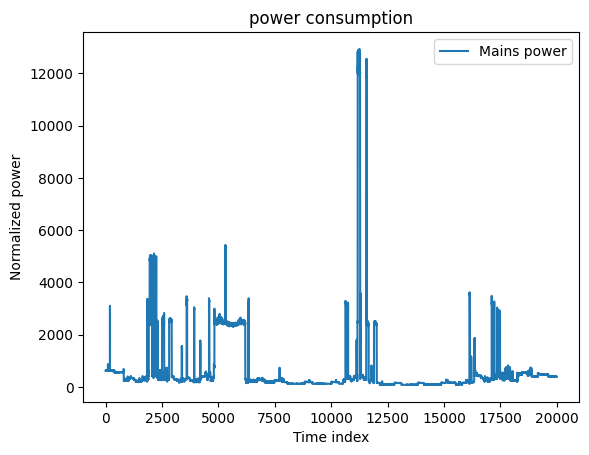

In [11]:
import matplotlib.pyplot as plt

start_idx, end_idx = 0, 20000 

plt.figure()
plt.plot(range(start_idx, end_idx),
             mains_df[start_idx:end_idx], label='Mains power')
plt.title('power consumption')
plt.xlabel('Time index')
plt.ylabel('Normalized power')
plt.legend()
plt.show()

In [12]:
#4. Process the data
submeters_lst = [(app, [app_df[app]]) for app in appliances]
_ = im2seq.call_preprocessing([mains_df], submeters_lst, method='train')


In [13]:
#5. Disaggregate the mains data
processed = im2seq.call_preprocessing([mains_df], None, method='test')

pred_dfs = im2seq.disaggregate_chunk(processed)


1251/1251 [==============================] - 556s 444ms/step


In [ ]:

df = pred_dfs[0]


df['microwave'] = df['microwave'].where(df['microwave'] <= 500, 1200)


In [15]:
from sklearn.metrics import mean_absolute_error

L    = im2seq.sequence_length      
half = L // 2                      

mae_scores = {}

for app in appliances:
    pred_full = pred_dfs[0][app].values       # predicted values
    pred_trimmed = pred_full[half: - half]  # trim the prediction to match the ground truth length

    mae = mean_absolute_error(app_df[app].squeeze().values , pred_trimmed)
    mae_scores[app] = mae
    print(f"{app:15s} MAE: {mae:.3f}")


dishwasher      MAE: 64.703
fridge_freezer  MAE: 23.353
washing_machine MAE: 62.652
microwave       MAE: 2.561


dishwasher      MAE: 64.703


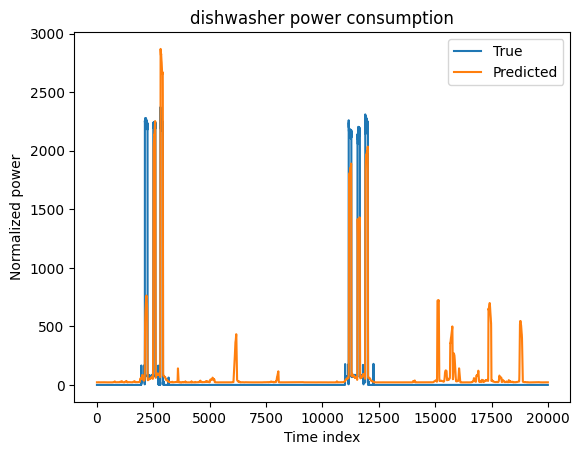

fridge_freezer  MAE: 23.353


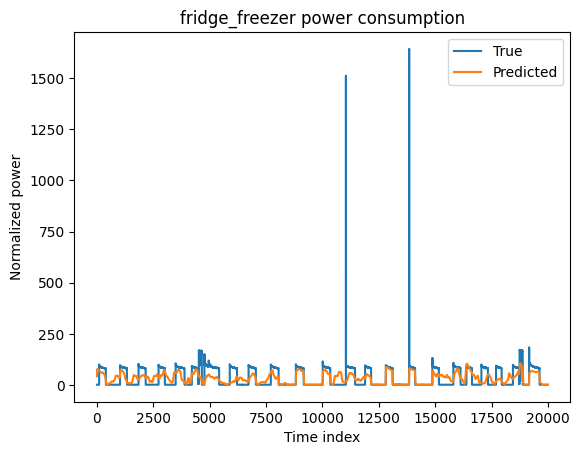

washing_machine MAE: 62.652


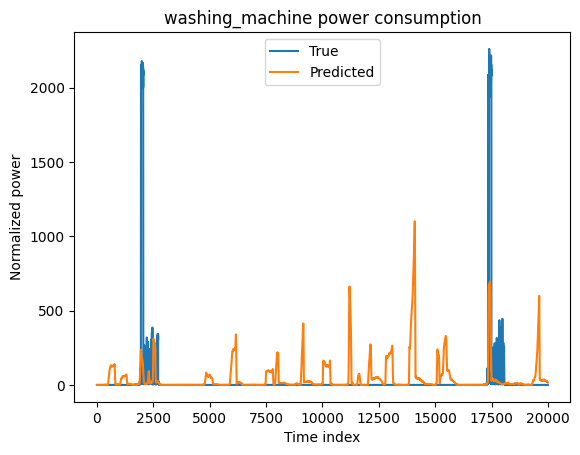

microwave       MAE: 2.561


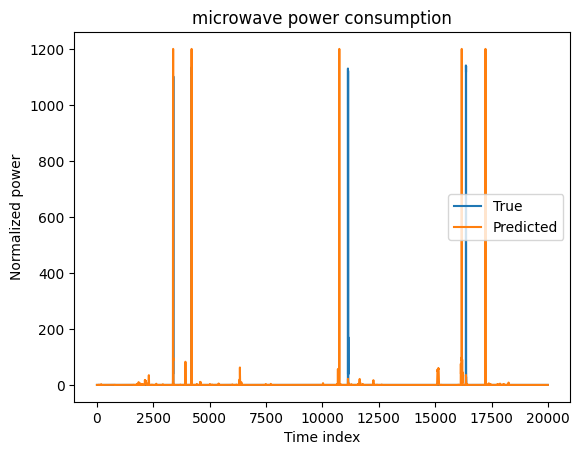

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

half = sequence_length // 2          # 225 for L = 450
start_idx, end_idx = 0, 20000       # plot window


mae_scores = {}

for app in appliances:
    y_hat, y_true = align(pred_dfs[0][app].values,
                          app_df[app][app].values,
                          half)

    mae_scores[app] = mean_absolute_error(y_true, y_hat)
    print(f'{app:15s} MAE: {mae_scores[app]:.3f}')

    if end_idx > len(y_hat):
        raise ValueError(f'end_idx ({end_idx}) exceeds series length '
                         f'{len(y_hat)} for {app}')

    plt.figure()
    plt.plot(range(start_idx, end_idx),
             y_true[start_idx:end_idx], label='True')
    plt.plot(range(start_idx, end_idx),
             y_hat[start_idx:end_idx],  label='Predicted')
    plt.title(f'{app} power consumption')
    plt.xlabel('Time index')
    plt.ylabel('Normalized power')
    plt.legend()
    plt.show()
